In [5]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 266.3/266.3 MB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 12.0 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ---------------------------------------- 6.0/6.0 MB 13.7 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 10.9 MB/s eta 0:00:00
     ------------------------------------- 895.9/895.9 kB 14.1 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 13.4 MB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     ------------------------------------- 439.2/439.2 kB 13.4 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 3.8 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 1.5/1.5 MB

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import tensorflow as tf
import numpy as np
import glob
import os
from PIL import Image , ImageOps


In [78]:

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x = list()
y = list()

#@markdown > The number of images to load from the dataset. By default 400 images are loaded.
num_images = 400 #@param {type: "number" }

image_dir = 'cityscape_images/images'
image_filenames = os.listdir( image_dir )
for filename in image_filenames[ 0 : 100 ]:
    image = Image \
        .open(os.path.join( image_dir, filename))
    x.append( np.asarray( ImageOps.crop( image , ( 0 , 0 , 256 , 0 ) ).resize( ( 128, 128 )) ) )
    y.append(np.asarray( ImageOps.crop(image, (256, 0, 0, 0)).resize( ( 128 , 128 ) ) ))

x = np.array( x ) / 255
y = np.array( y )

train_features, test_features, train_labels, test_labels = train_test_split(np.array(x), np.array(y),test_size=0.4)

def binarize( pixel ):
    if np.array_equal( pixel , [ 128 , 63 , 127 ]):
        return np.array( [ 1 ] )
    else :
        return np.array( [ 0 ] )

train_labels = np.apply_along_axis( binarize , axis=3 , arr=train_labels ) 
test_labels = np.apply_along_axis( binarize , axis=3 , arr=test_labels ) 

#@markdown > The batch size for the dataset.
batch_size = 5  #@param {type: "number"}

train_dataset = tf.data.Dataset.from_tensor_slices( ( train_features , train_labels ) )
train_dataset = train_dataset.shuffle( 1024 ).batch( batch_size )
test_dataset = tf.data.Dataset.from_tensor_slices( ( test_features , test_labels ) )
test_dataset = test_dataset.shuffle( 1024 ).batch( batch_size )

(60, 128, 128, 3)
(40, 128, 128, 3)


In [80]:
print(np.shape(train_features))
print(np.shape(test_features))
print( np.shape(test_labels))
print(np.shape(train_labels))

(60, 128, 128, 3)
(40, 128, 128, 3)
(40, 128, 128, 1)
(60, 128, 128, 1)


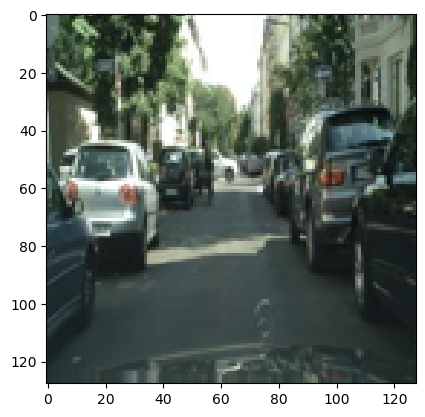

0


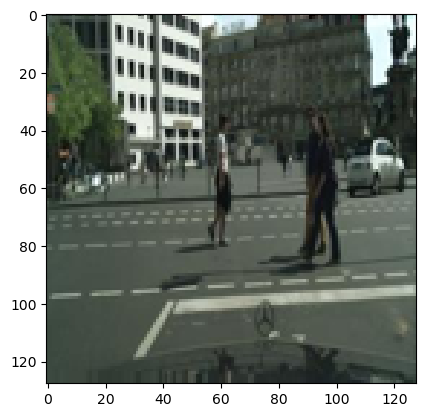

1


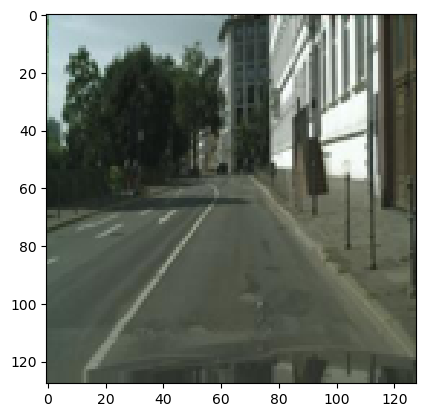

2


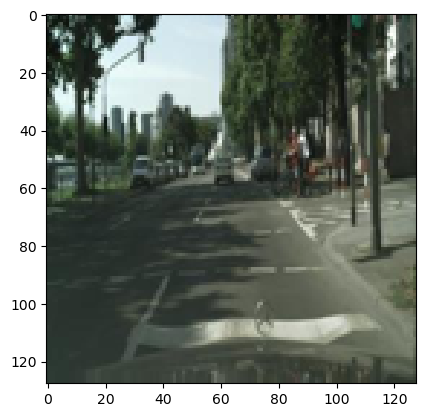

3


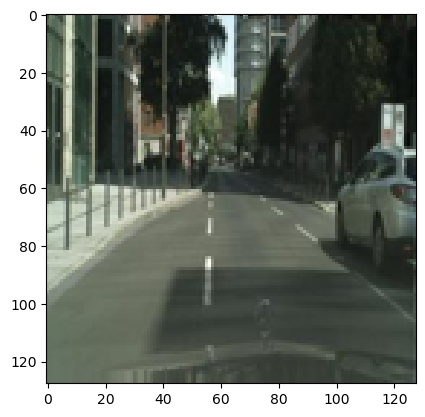

4


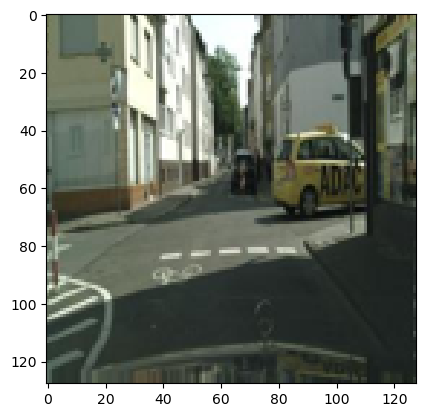

0


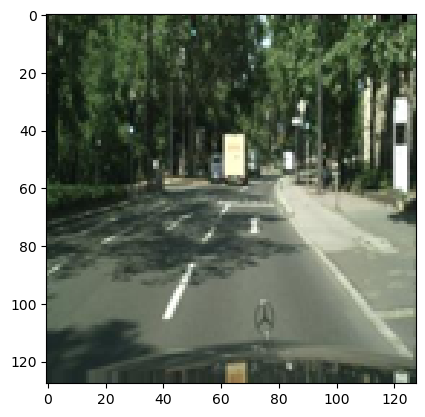

1


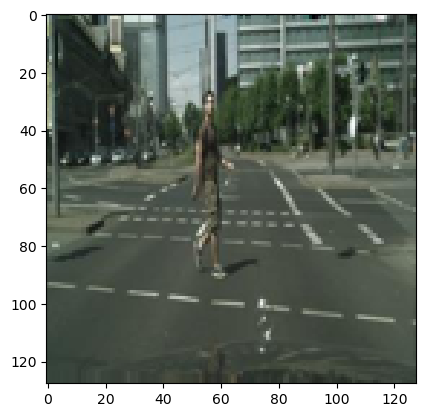

2


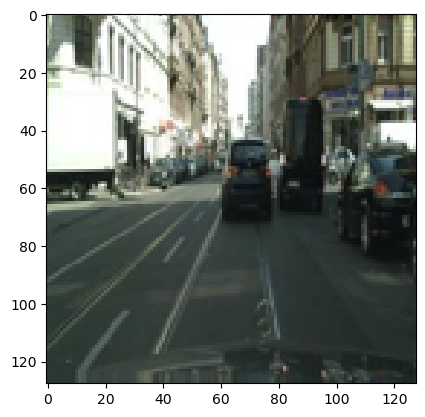

3


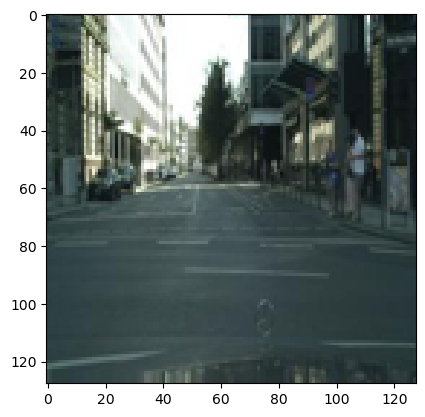

4


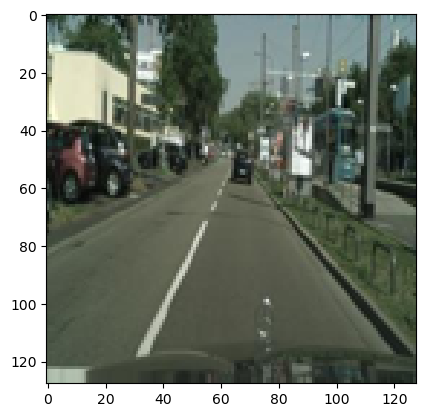

0


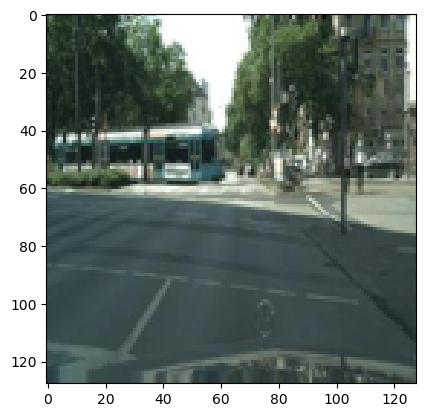

1


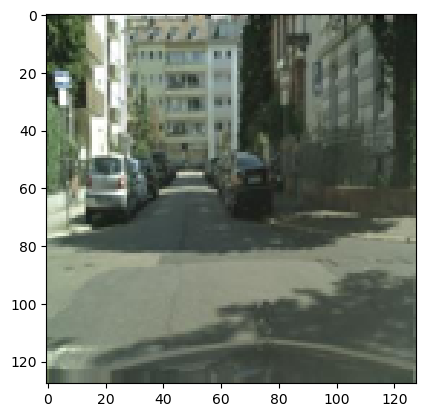

2


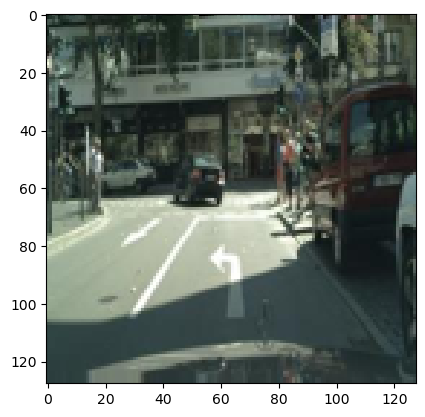

3


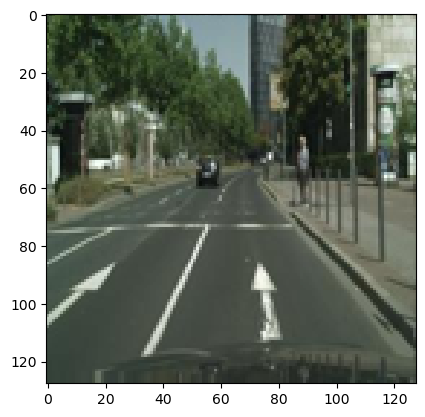

4


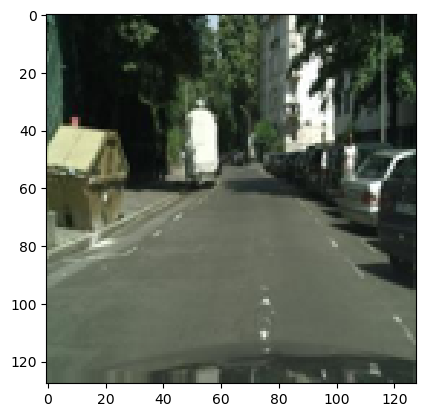

0


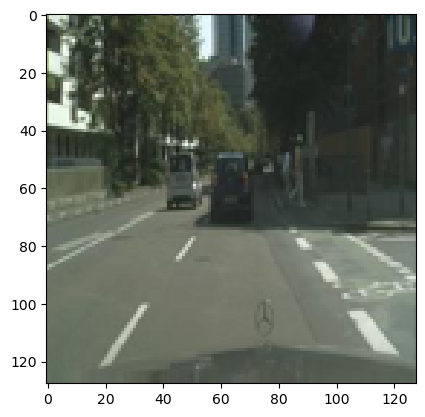

1


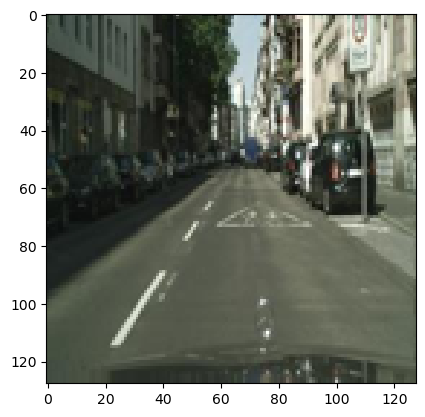

2


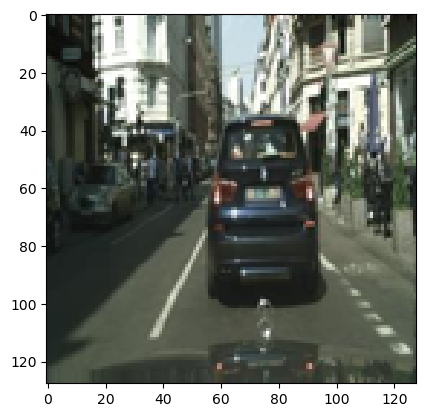

3


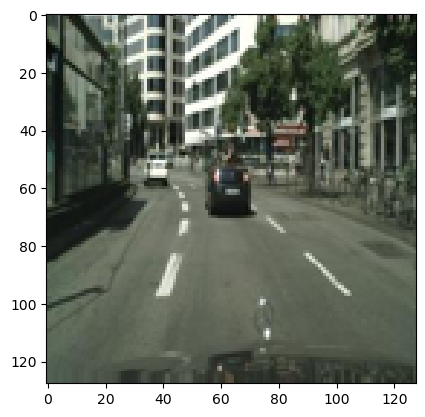

4


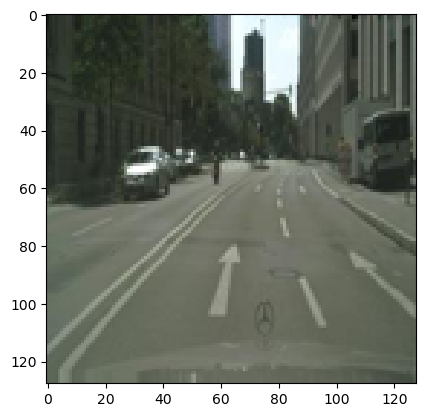

0


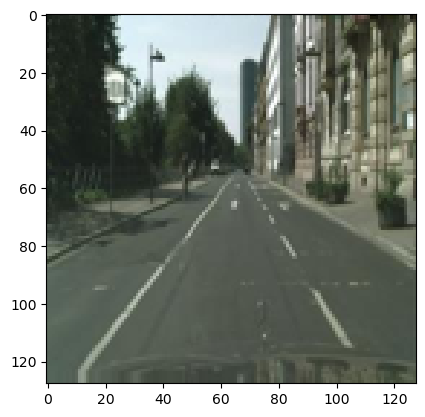

1


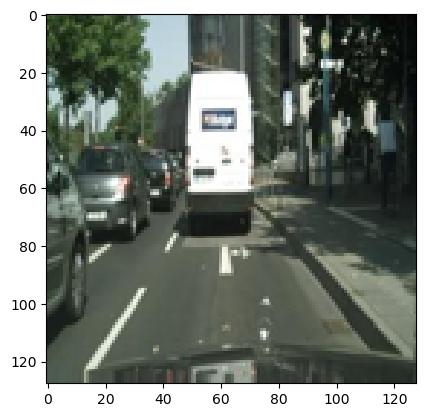

2


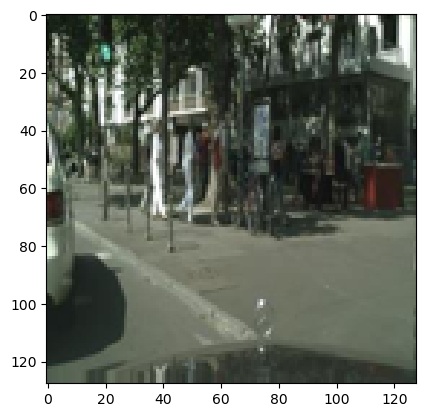

3


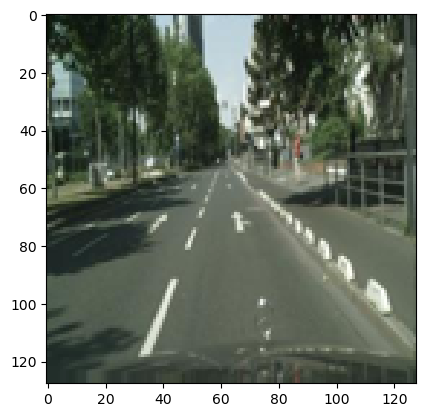

4


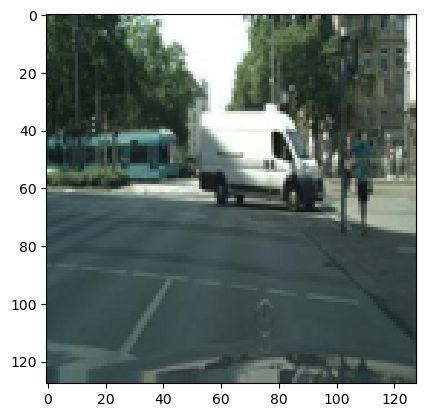

0


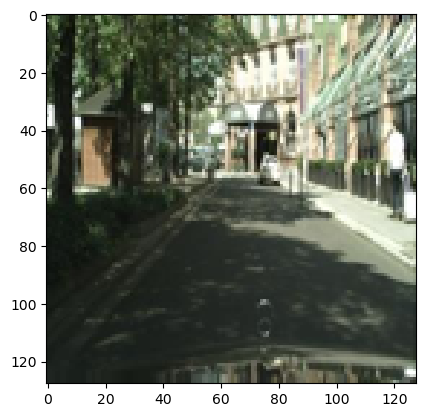

1


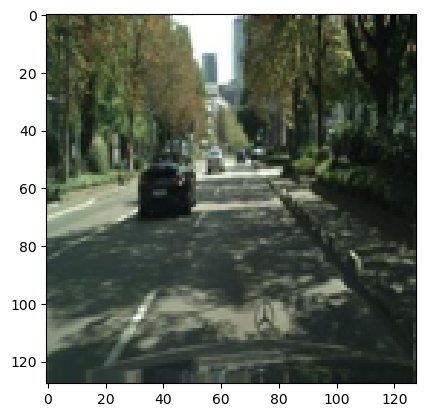

2


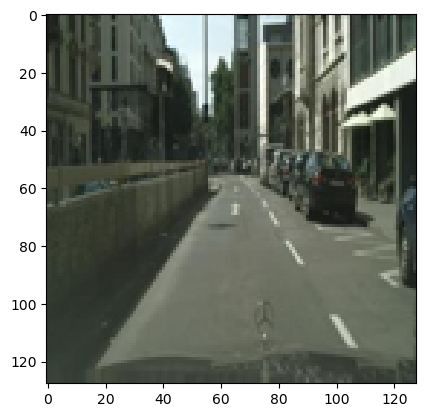

3


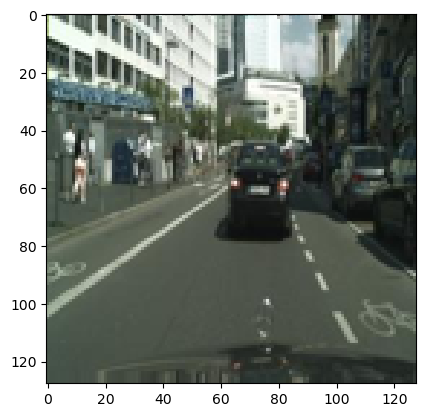

4


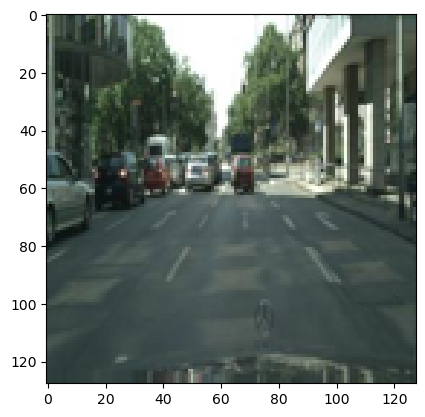

0


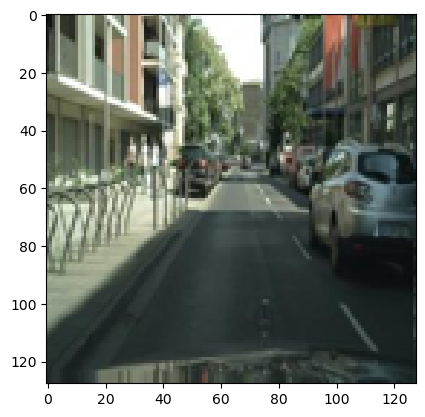

1


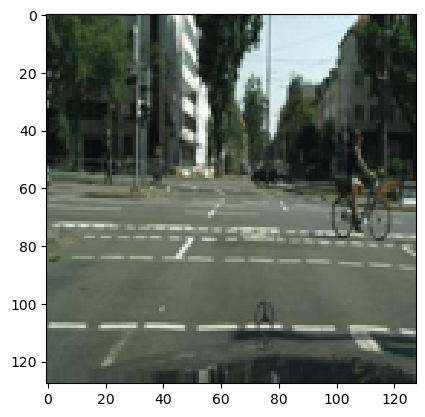

2


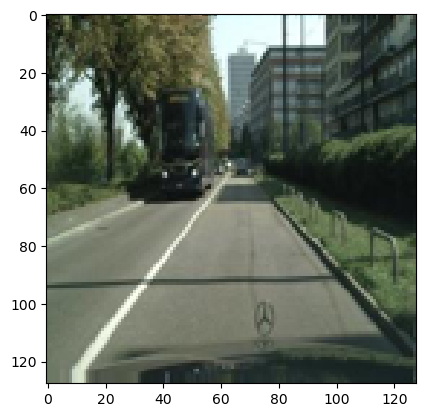

3


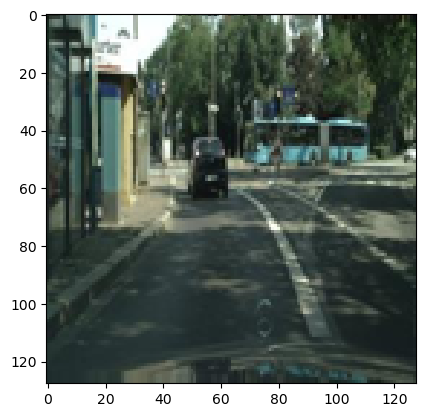

4


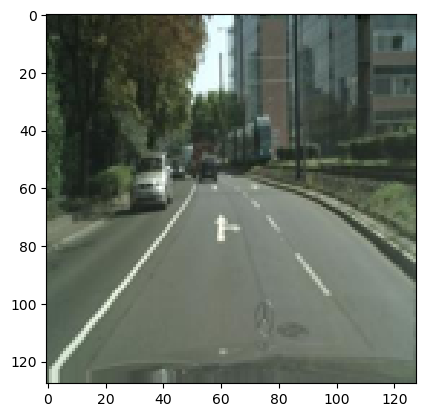

0


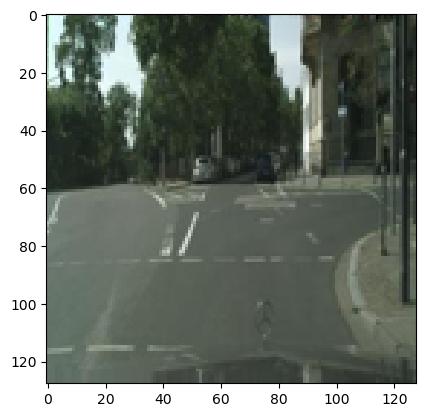

1


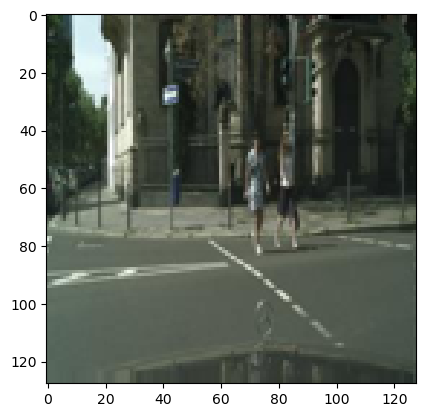

2


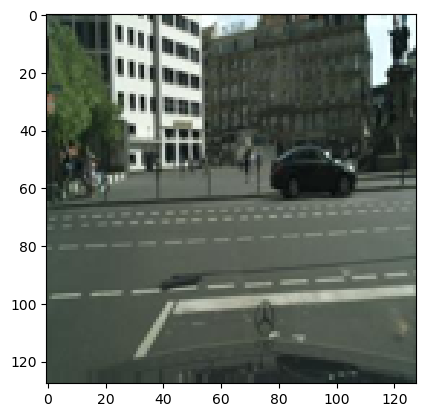

3


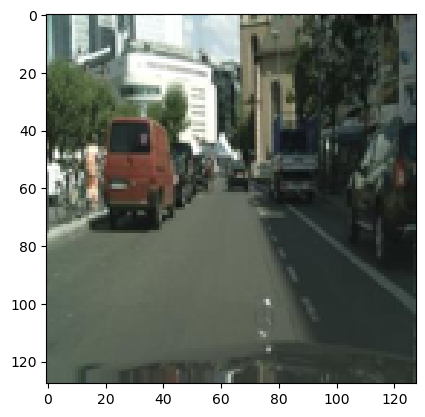

4


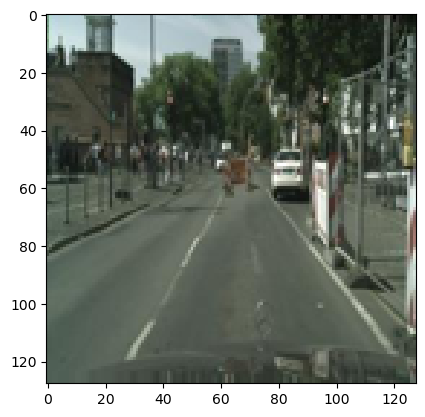

0


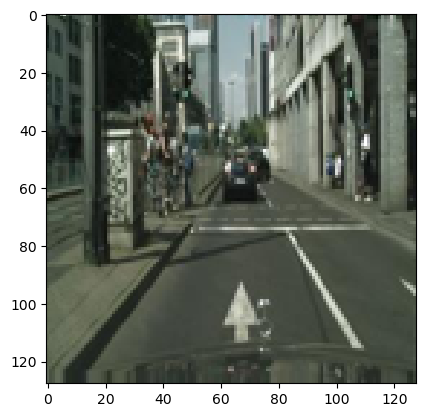

1


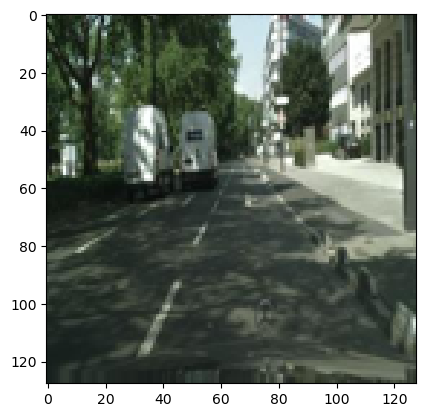

2


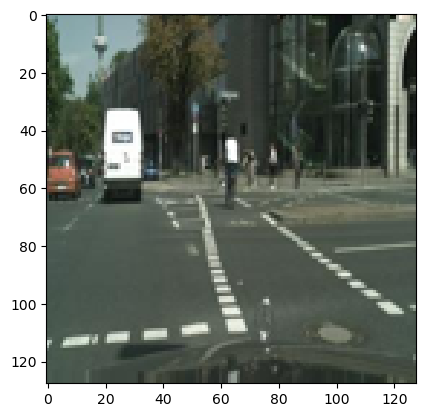

3


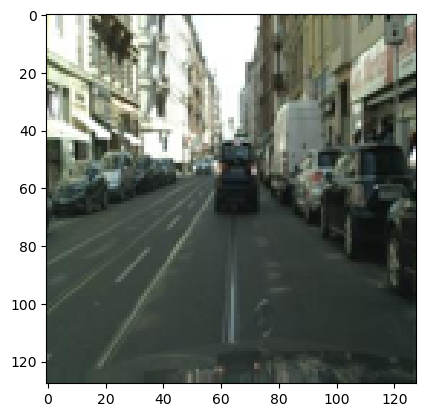

4


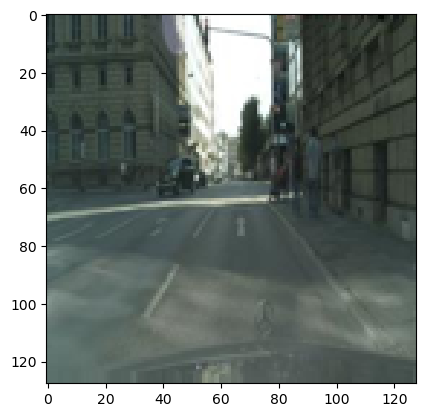

0


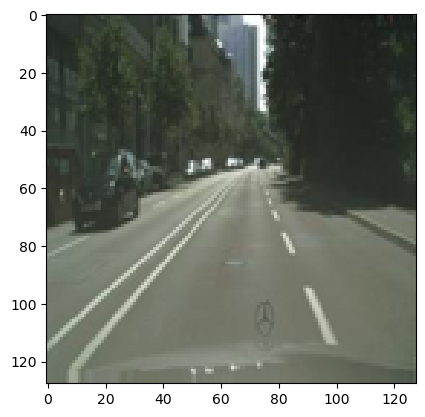

1


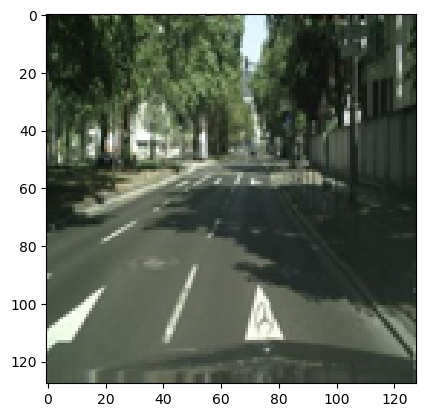

2


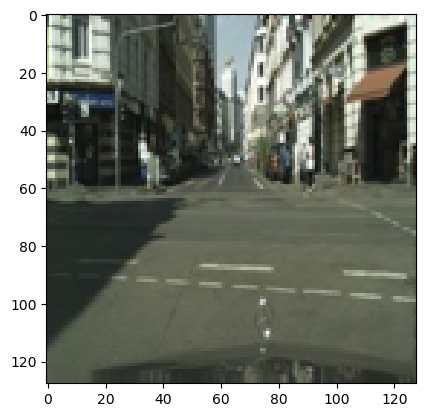

3


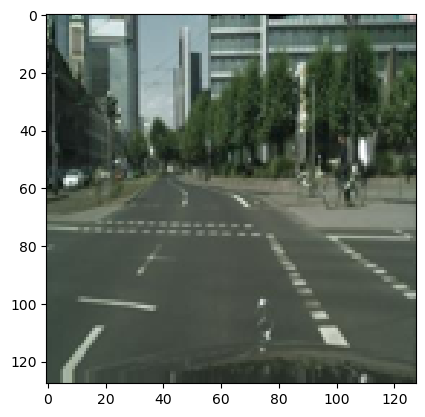

4


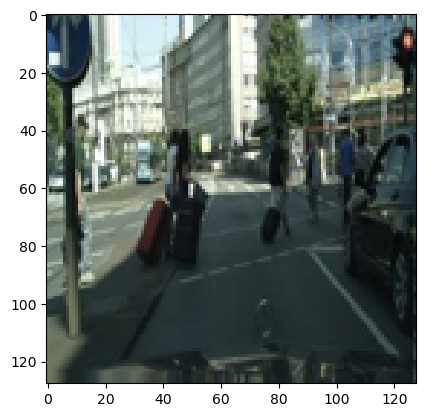

0


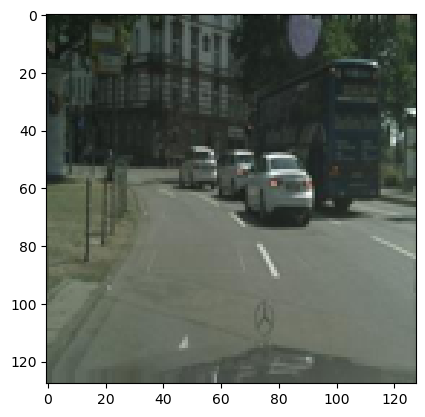

1


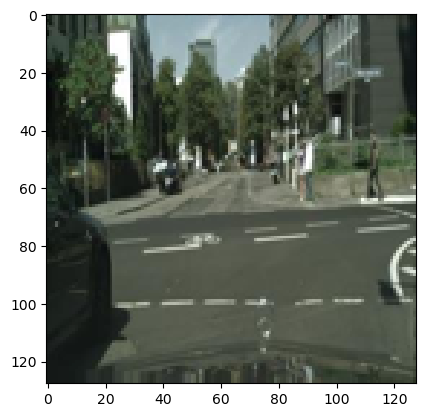

2


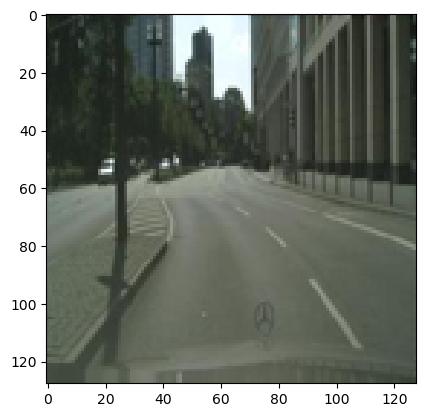

3


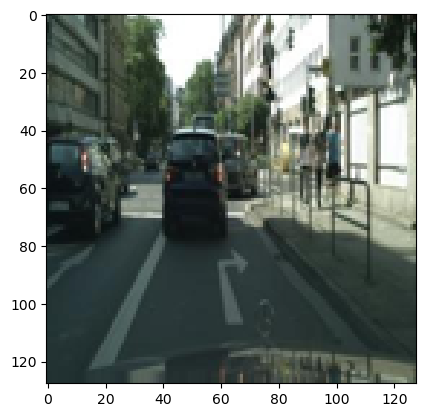

4


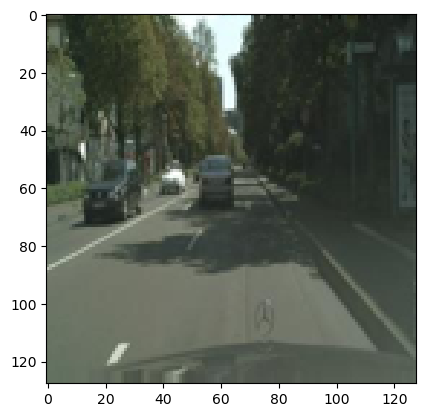

0


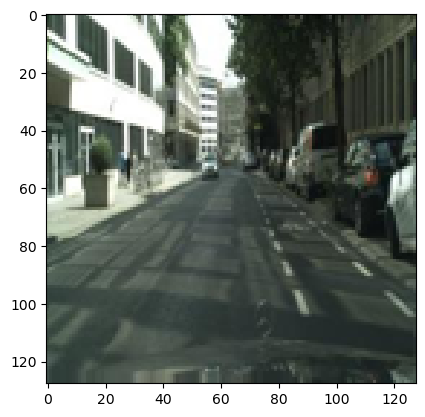

1


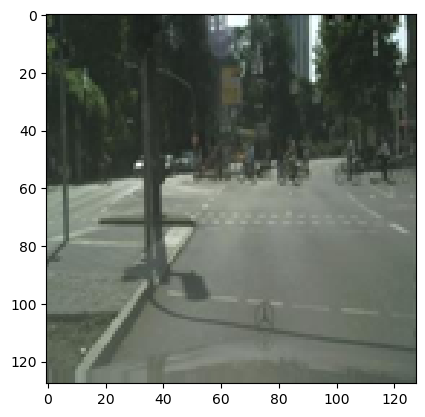

2


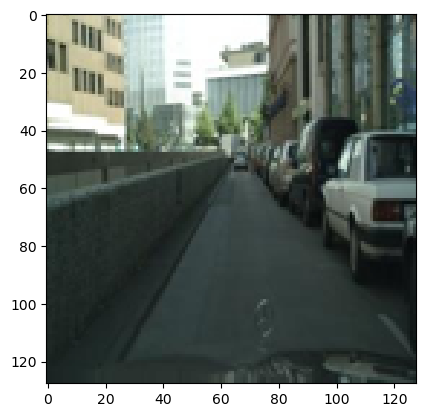

3


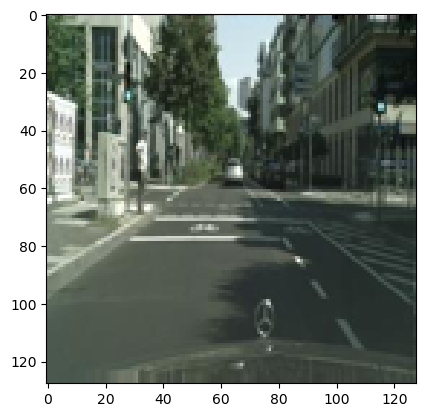

4
12


In [75]:

n = (len(train_dataset))
s = 0
for i in train_dataset :
    f = plt.figure()
    image , label = i 
    s = s+1
    for j in range(batch_size) : 
        plt.imshow(image[j] , interpolation='none' )
        plt.show()
        print(j)
    
print(s)        


In [76]:
print(np.shape(image))
data_size = s*5
print(data_size)
print(train_dataset)

(5, 128, 128, 3)
60
<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [12]:

#@markdown > ReLU slope for `tf.nn.leaky_relu`
relu_alpha = 0.2  #@param {type: "number"}

#@markdown > Dropout rate for `tf.nn.dropout`
dropout_rate = 0.5  #@param {type: "number"}

#@markdown > The padding for the convolution layers.
padding = 'SAME' #@param [ 'SAME' , 'VALID' ]


def conv2d_down( inputs , filters , stride_size ):
    out = tf.nn.conv2d( inputs , filters , strides=stride_size , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=0.2 ) 

def maxpool_down( inputs , pool_size , stride_size ):
    return tf.nn.max_pool( inputs , ksize=pool_size , padding='VALID' , strides=stride_size )

def conv2d_up( inputs , filters , stride_size , output_shape ):
    out = tf.nn.conv2d_transpose( inputs , filters , output_shape=output_shape , strides=stride_size , padding=padding ) 
    return tf.nn.leaky_relu( out , alpha=0.2 ) 

def maxpool_up( inputs , size ):
    in_dimen = tf.shape( inputs )[ 1 ]
    out_dimen = tf.cast( tf.round( in_dimen * size ) , dtype=tf.int32 ) 
    return tf.image.resize( inputs , [ out_dimen , out_dimen ] , method='nearest' ) 

In [13]:
initializer = tf.initializers.glorot_uniform()
def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True )

shapes = [
    [ 3 , 3 , 3 , 16 ] , 
    [ 3 , 3 , 16 , 16 ] , 

    [ 3 , 3 , 16 , 32 ] , 
    [ 3 , 3 , 32 , 32 ] ,

    [ 3 , 3 , 32 , 64 ] , 
    [ 3 , 3 , 64 , 64 ] ,

    [ 3 , 3 , 64 , 128 ] , 
    [ 3 , 3 , 128 , 128 ] ,

    [ 3 , 3 , 128 , 256 ] , 
    [ 3 , 3 , 256 , 256 ] ,

    [ 3 , 3 , 128 , 384 ],
    [ 3 , 3 , 128 , 128 ],

    [ 3 , 3 , 64 , 192 ],
    [ 3 , 3 , 64 , 64 ],

    [ 3 , 3 , 32 , 96 ],
    [ 3 , 3 , 32 , 32 ],

    [ 3 , 3 , 16 , 48 ],
    [ 3 , 3 , 16 , 16 ],

    [ 1 , 1 , 16 , 1 ],
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )

C:\Users\khale\AppData\Roaming\Python\Python39\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
def model( x ) :
    batch_size = tf.shape( x )[0]
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d_down( x , weights[ 0 ] , stride_size=1 ) 
    c1 = conv2d_down( c1 , weights[ 1 ] , stride_size=1 ) 
    p1 = maxpool_down( c1 , pool_size=2 , stride_size=2 )
    
    c2 = conv2d_down( p1 , weights[ 2 ] , stride_size=1 )
    c2 = conv2d_down( c2 , weights[ 3 ] , stride_size=1 ) 
    p2 = maxpool_down( c2 , pool_size=2 , stride_size=2 )
    
    c3 = conv2d_down( p2 , weights[ 4 ] , stride_size=1 ) 
    c3 = conv2d_down( c3 , weights[ 5 ] , stride_size=1 ) 
    p3 = maxpool_down( c3 , pool_size=2 , stride_size=2 )
    
    c4 = conv2d_down( p3 , weights[ 6 ] , stride_size=1 )
    c4 = conv2d_down( c4 , weights[ 7 ] , stride_size=1 )
    p4 = maxpool_down( c4 , pool_size=2 , stride_size=2 )

    c5 = conv2d_down( p4 , weights[ 8 ] , stride_size=1 )
    c5 = conv2d_down( c5 , weights[ 9 ] , stride_size=1 ) 
        
    p5 = maxpool_up( c5 , 2 )
    concat_1 = tf.concat( [ p5 , c4 ] , axis=-1 ) 
    c6 = conv2d_up( concat_1 , weights[ 10 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )
    c6 = conv2d_up( c6 , weights[ 11 ] , stride_size=1 , output_shape=[ batch_size , 16 , 16 , 128 ] )  

    p6 = maxpool_up( c6 , 2 )
    concat_2 = tf.concat( [ p6 , c3 ] , axis=-1 ) 
    c7 = conv2d_up( concat_2 , weights[ 12 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )
    c7 = conv2d_up( c7 , weights[ 13 ] , stride_size=1 , output_shape=[ batch_size , 32 , 32 , 64 ] )  

    p7 = maxpool_up( c7 , 2 )
    concat_3 = tf.concat( [ p7 , c2 ] , axis=-1 ) 
    c8 = conv2d_up( concat_3 , weights[ 14 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )
    c8 = conv2d_up( c8 , weights[ 15 ] , stride_size=1 , output_shape=[ batch_size , 64 , 64 , 32 ] )   

    p8 = maxpool_up( c8 , 2 )
    concat_4 = tf.concat( [ p8 , c1 ] , axis=-1 ) 
    c9 = conv2d_up( concat_4 , weights[ 16 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )
    c9 = conv2d_up( c9 , weights[ 17 ] , stride_size=1 , output_shape=[ batch_size , 128 , 128 , 16 ] )   

    output = tf.nn.conv2d( c9 , weights[ 18 ] , strides=[ 1 , 1 , 1 , 1 ] , padding=padding ) 
    outputs = tf.nn.sigmoid( output ) 
    return outputs

In [15]:
def loss( pred , target ):
    return tf.losses.binary_crossentropy( target , pred )

learning_rate = 0.001
optimizer = tf.optimizers.Adam( learning_rate=learning_rate )

def train( model, inputs , outputs ):
    with tf.GradientTape() as tape:
        current_loss = loss( model( inputs ), outputs)
    grads = tape.gradient( current_loss , weights )
    optimizer.apply_gradients( zip( grads , weights ) )
    print( tf.reduce_mean( current_loss ) )

In [29]:
import datetime

logdir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer( logdir + "/metrics")
file_writer.set_as_default()
num_epochs = 100  #@param {type: "number"}

for e in range( num_epochs ):
    print( 'Epoch {} out of {} {}'.format( e + 1 , num_epochs , '--' * 50 ) )
    for features in train_dataset:
        image , label = features
        train( model , image , label )

Epoch 1 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.07844895, shape=(), dtype=float32)
tf.Tensor(0.09173946, shape=(), dtype=float32)
tf.Tensor(0.09634717, shape=(), dtype=float32)
tf.Tensor(0.09949936, shape=(), dtype=float32)
tf.Tensor(0.090145335, shape=(), dtype=float32)
tf.Tensor(0.09101416, shape=(), dtype=float32)
tf.Tensor(0.08729169, shape=(), dtype=float32)
tf.Tensor(0.07519455, shape=(), dtype=float32)
tf.Tensor(0.1316537, shape=(), dtype=float32)
tf.Tensor(0.08957497, shape=(), dtype=float32)
tf.Tensor(0.0846139, shape=(), dtype=float32)
tf.Tensor(0.08695668, shape=(), dtype=float32)
Epoch 2 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.0743205, shape=(), dtype=float32)
tf.Tensor(0.072773896, shape=(), dtype=float32)
tf.Tensor(0.07296673, shape=(), dtype=float32)
tf.Tensor(0.06400807, shape=(), dtype=float32)
tf.Tensor

tf.Tensor(0.05006219, shape=(), dtype=float32)
Epoch 13 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.044902176, shape=(), dtype=float32)
tf.Tensor(0.03757116, shape=(), dtype=float32)
tf.Tensor(0.04509489, shape=(), dtype=float32)
tf.Tensor(0.037588477, shape=(), dtype=float32)
tf.Tensor(0.040828913, shape=(), dtype=float32)
tf.Tensor(0.04349214, shape=(), dtype=float32)
tf.Tensor(0.039930545, shape=(), dtype=float32)
tf.Tensor(0.04512603, shape=(), dtype=float32)
tf.Tensor(0.03508957, shape=(), dtype=float32)
tf.Tensor(0.038422406, shape=(), dtype=float32)
tf.Tensor(0.045614675, shape=(), dtype=float32)
tf.Tensor(0.036949433, shape=(), dtype=float32)
Epoch 14 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.02974075, shape=(), dtype=float32)
tf.Tensor(0.04269587, shape=(), dtype=float32)
tf.Tensor(0.035163958, shape=(), dtype=float32

tf.Tensor(0.027141392, shape=(), dtype=float32)
tf.Tensor(0.025141072, shape=(), dtype=float32)
tf.Tensor(0.03323608, shape=(), dtype=float32)
Epoch 25 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.0197952, shape=(), dtype=float32)
tf.Tensor(0.024910592, shape=(), dtype=float32)
tf.Tensor(0.035727385, shape=(), dtype=float32)
tf.Tensor(0.023924012, shape=(), dtype=float32)
tf.Tensor(0.031074578, shape=(), dtype=float32)
tf.Tensor(0.029395614, shape=(), dtype=float32)
tf.Tensor(0.03412379, shape=(), dtype=float32)
tf.Tensor(0.02546518, shape=(), dtype=float32)
tf.Tensor(0.026708957, shape=(), dtype=float32)
tf.Tensor(0.027758693, shape=(), dtype=float32)
tf.Tensor(0.026582211, shape=(), dtype=float32)
tf.Tensor(0.02610961, shape=(), dtype=float32)
Epoch 26 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.030177888, shape=(), dtype=float

tf.Tensor(0.012918435, shape=(), dtype=float32)
tf.Tensor(0.017812341, shape=(), dtype=float32)
tf.Tensor(0.018744431, shape=(), dtype=float32)
tf.Tensor(0.01682781, shape=(), dtype=float32)
tf.Tensor(0.017135654, shape=(), dtype=float32)
tf.Tensor(0.01825948, shape=(), dtype=float32)
Epoch 37 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.01900308, shape=(), dtype=float32)
tf.Tensor(0.016340898, shape=(), dtype=float32)
tf.Tensor(0.016516013, shape=(), dtype=float32)
tf.Tensor(0.017490946, shape=(), dtype=float32)
tf.Tensor(0.018741518, shape=(), dtype=float32)
tf.Tensor(0.016746845, shape=(), dtype=float32)
tf.Tensor(0.014030315, shape=(), dtype=float32)
tf.Tensor(0.018092668, shape=(), dtype=float32)
tf.Tensor(0.0136385085, shape=(), dtype=float32)
tf.Tensor(0.021590864, shape=(), dtype=float32)
tf.Tensor(0.017551068, shape=(), dtype=float32)
tf.Tensor(0.02371712, shape=(), dtype=float32)
Epoch 38 out of 10

tf.Tensor(0.019865176, shape=(), dtype=float32)
tf.Tensor(0.015960287, shape=(), dtype=float32)
tf.Tensor(0.016124343, shape=(), dtype=float32)
tf.Tensor(0.017021019, shape=(), dtype=float32)
tf.Tensor(0.016325464, shape=(), dtype=float32)
tf.Tensor(0.014314257, shape=(), dtype=float32)
tf.Tensor(0.0152681125, shape=(), dtype=float32)
tf.Tensor(0.01307145, shape=(), dtype=float32)
tf.Tensor(0.016808933, shape=(), dtype=float32)
Epoch 49 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.017165422, shape=(), dtype=float32)
tf.Tensor(0.016735151, shape=(), dtype=float32)
tf.Tensor(0.020036904, shape=(), dtype=float32)
tf.Tensor(0.01749089, shape=(), dtype=float32)
tf.Tensor(0.014891003, shape=(), dtype=float32)
tf.Tensor(0.015364869, shape=(), dtype=float32)
tf.Tensor(0.012421688, shape=(), dtype=float32)
tf.Tensor(0.012694824, shape=(), dtype=float32)
tf.Tensor(0.01575102, shape=(), dtype=float32)
tf.Tensor(0.01424

tf.Tensor(0.014147893, shape=(), dtype=float32)
tf.Tensor(0.010817057, shape=(), dtype=float32)
tf.Tensor(0.016084772, shape=(), dtype=float32)
tf.Tensor(0.010202734, shape=(), dtype=float32)
tf.Tensor(0.015572217, shape=(), dtype=float32)
tf.Tensor(0.012977583, shape=(), dtype=float32)
tf.Tensor(0.012060684, shape=(), dtype=float32)
tf.Tensor(0.016783308, shape=(), dtype=float32)
tf.Tensor(0.013507983, shape=(), dtype=float32)
tf.Tensor(0.014444706, shape=(), dtype=float32)
tf.Tensor(0.015356069, shape=(), dtype=float32)
tf.Tensor(0.014783991, shape=(), dtype=float32)
Epoch 61 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.015517491, shape=(), dtype=float32)
tf.Tensor(0.016486656, shape=(), dtype=float32)
tf.Tensor(0.016412657, shape=(), dtype=float32)
tf.Tensor(0.01475555, shape=(), dtype=float32)
tf.Tensor(0.012018554, shape=(), dtype=float32)
tf.Tensor(0.014596323, shape=(), dtype=float32)
tf.Tensor(0.0137

tf.Tensor(0.011347629, shape=(), dtype=float32)
tf.Tensor(0.009630477, shape=(), dtype=float32)
tf.Tensor(0.013500735, shape=(), dtype=float32)
tf.Tensor(0.012551633, shape=(), dtype=float32)
tf.Tensor(0.008336936, shape=(), dtype=float32)
tf.Tensor(0.0120118465, shape=(), dtype=float32)
tf.Tensor(0.008560144, shape=(), dtype=float32)
tf.Tensor(0.010327478, shape=(), dtype=float32)
tf.Tensor(0.010057226, shape=(), dtype=float32)
tf.Tensor(0.012210982, shape=(), dtype=float32)
tf.Tensor(0.011510983, shape=(), dtype=float32)
tf.Tensor(0.008496942, shape=(), dtype=float32)
Epoch 73 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.010569549, shape=(), dtype=float32)
tf.Tensor(0.011144051, shape=(), dtype=float32)
tf.Tensor(0.012496038, shape=(), dtype=float32)
tf.Tensor(0.009180655, shape=(), dtype=float32)
tf.Tensor(0.010768006, shape=(), dtype=float32)
tf.Tensor(0.011904865, shape=(), dtype=float32)
tf.Tensor(0.01

tf.Tensor(0.014453267, shape=(), dtype=float32)
tf.Tensor(0.011746031, shape=(), dtype=float32)
tf.Tensor(0.010616657, shape=(), dtype=float32)
tf.Tensor(0.019630652, shape=(), dtype=float32)
tf.Tensor(0.014107199, shape=(), dtype=float32)
tf.Tensor(0.014448521, shape=(), dtype=float32)
tf.Tensor(0.01604442, shape=(), dtype=float32)
tf.Tensor(0.013539764, shape=(), dtype=float32)
tf.Tensor(0.012118329, shape=(), dtype=float32)
tf.Tensor(0.015711948, shape=(), dtype=float32)
tf.Tensor(0.011873186, shape=(), dtype=float32)
tf.Tensor(0.011852229, shape=(), dtype=float32)
Epoch 85 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.010909356, shape=(), dtype=float32)
tf.Tensor(0.011265764, shape=(), dtype=float32)
tf.Tensor(0.011281112, shape=(), dtype=float32)
tf.Tensor(0.013565051, shape=(), dtype=float32)
tf.Tensor(0.01422814, shape=(), dtype=float32)
tf.Tensor(0.012595874, shape=(), dtype=float32)
tf.Tensor(0.01432

tf.Tensor(0.008004969, shape=(), dtype=float32)
Epoch 96 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.0076725883, shape=(), dtype=float32)
tf.Tensor(0.006913478, shape=(), dtype=float32)
tf.Tensor(0.011303736, shape=(), dtype=float32)
tf.Tensor(0.009474231, shape=(), dtype=float32)
tf.Tensor(0.0076765893, shape=(), dtype=float32)
tf.Tensor(0.00868742, shape=(), dtype=float32)
tf.Tensor(0.010829019, shape=(), dtype=float32)
tf.Tensor(0.009709954, shape=(), dtype=float32)
tf.Tensor(0.010156545, shape=(), dtype=float32)
tf.Tensor(0.007559657, shape=(), dtype=float32)
tf.Tensor(0.00888768, shape=(), dtype=float32)
tf.Tensor(0.00804859, shape=(), dtype=float32)
Epoch 97 out of 100 ----------------------------------------------------------------------------------------------------
tf.Tensor(0.009295258, shape=(), dtype=float32)
tf.Tensor(0.010366416, shape=(), dtype=float32)
tf.Tensor(0.008280191, shape=(), dtype=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 128, 128, 3)


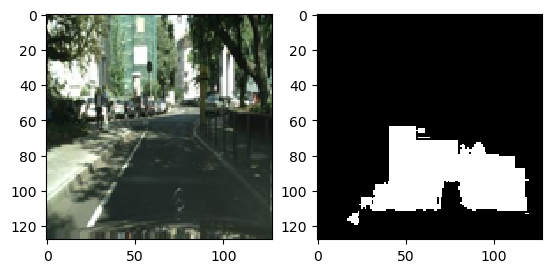

In [40]:
import matplotlib.pyplot as plt

input_image = test_features[0:1]
pred = model( input_image ).numpy()
image = np.zeros( ( 128 , 128 , 3 ) )
for x in range( 128 ):
    for y in range( 128 ):
        if pred[ 0 , x , y ] > 0.5 :
            image[ x , y ] = [ 255 , 255 , 255 ]
        else:
            image[ x , y ] = [ 0, 0, 0]

def show_images(images: list):
    n = len(images)
    print(np.shape(images))
    f = plt.figure()
    for i in range(n):
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i] , interpolation='none' )
    plt.show()

show_images( [ test_features[1] , image ] )


In [96]:
m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
m.update_state([1, 0, 1, 1], [0, 0, 1, 1])
m.result().numpy()

0.5